In [ ]:
%load_ext autoreload
%autoreload

import sys
# https://proceedings.neurips.cc/paper/2020/file/fdbe012e2e11314b96402b32c0df26b7-Paper.pdf
# http://proceedings.mlr.press/v48/wei16.pdf

sys.path.append("../../")

from dmp.data.pmlb import pmlb_loader
import dmp.task.aspect_test.aspect_test_utils as aspect_test_utils
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as numpy 
from pmlb import fetch_data
from tensorflow import keras
import tensorflow as tf
from typing import Iterable
import sklearn.model_selection
import numpy.ma as ma
from functools import *

_datasets = pmlb_loader.load_dataset_index()


In [ ]:
%store -r scaling_4_2
%store -r size_weighted_0
%store -r size_weighted_1
%store -r test_excess_weighted_1
%store -r size_weighted_together_1
%store -r size_weighted_together_nofreeze_1
%store -r base_size
%store -r num_networks
%store -r configs
%store -r equal_sizes
%store -r sizes
%store -r dataset
%store -r adam_0_001
%store -r full_trace_128
%store -r full_trace_96
%store -r full_trace_64
%store -r full_trace_32
%store -r full_trace_16
%store -r fg_0
%store -r fgs_0
%store -r fgs_1
%store -r fgs_static_0
%store -r fgs_equal_0
%store -r fg_int_0
%store -r scaling_0
%store -r fg_int_0
%store -r fgs_equal_0
%store -r fgs_equal_1
%store -r fgs_equal_2
%store -r fgss_0
%store -r fgss_1
%store -r fgst_0
%store -r fgst_1
%store -r scaling_1
%store -r scaling_2
%store -r scaling_3
%store -r relative_scaling_1
%store -r relative_scaling_2
%store -r relative_scaling_3



In [27]:
def evaluate_model(model, inputs, outputs):
    return model.evaluate(inputs, outputs, verbose=False)

def make_model(dataset, widths, optimizer_config):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    model = keras.models.Sequential()
    model.add(tf.keras.Input(shape=inputs.shape[1:]))
    for width in widths:
        model.add(keras.layers.Dense(width, activation='relu',
                  kernel_initializer='he_normal'))
    model.add(keras.layers.Dense(
        outputs.shape[1], activation=output_activation, kernel_initializer='glorot_normal'))

    optimizer = tf.keras.optimizers.get(optimizer_config)
    model.compile(optimizer=optimizer,
                  loss=run_loss,
                  #   loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy', ],
                  )

    # print(model.summary())
    return model


def default_initializer(source_model, dest_model):
    for i, l in enumerate(source_model.layers):  # inserts old weights into new model
        old_width = l.output_shape[1]
        old_weights = l.get_weights()
        # new_weights = new_model.layers[i].get_weights()

        new_layer = dest_model.layers[i]
        new_weights = new_layer.get_weights()

        # new_weights[0] = new_weights[0] * 0
        # new_weights[1] = new_weights[1] * 0

        # print(
        #     f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

        new_weights[0][:old_weights[0].shape[0],
                       :old_weights[0].shape[1]] = old_weights[0]
        new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
        new_layer.set_weights(new_weights)


def grow_network_replace(dataset, source_model, new_widths, optimizer_config, initializer=default_initializer):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    dest_model = keras.Sequential()
    input_shape = source_model.input_shape

    # print(f'growing {len(source_model.layers)}')

    for i, l in enumerate(source_model.layers):  # adds modified layers to new model
        old_width = l.output_shape[1]
        new_width = new_widths[i] if len(new_widths) > i else old_width
        dest_model.add(keras.layers.Dense(
            new_width, activation=l.activation, kernel_initializer=l.kernel_initializer))

    dest_model.build(input_shape)  # makes new model (and initialized weights)

    initializer(source_model, dest_model)

    optimizer = tf.keras.optimizers.get(optimizer_config)
    dest_model.compile(optimizer=optimizer,
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['accuracy'])
    return dest_model


def plot_histories(configs, metric_trace, size_trace, x_axis_trace, color=None, colors=None):

    if color is not None:
        plt.plot(x_axis_trace,
                 metric_trace,
                 'o-',
                 markersize=2.5,
                 color=color,
                 alpha=.8,
                 linewidth=1.0,
                 )
        return

    sequence_number = 0
    def plot_sequence(x, y):
        nonlocal sequence_number

        c = color
        if colors is not None:
            c = colors[sequence_number % len(colors)]

        plt.plot(x,
                 y,
                 'o-',
                 markersize=2.5,
                 color=c,
                 alpha=.8,
                 linewidth=1.0,
                 )
        sequence_number += 1

    start = 0
    for i, s in enumerate(size_trace):
        if i > 0 and size_trace[i-1] != s:
            plot_sequence(x_axis_trace[start:i], metric_trace[start:i])
            start = i
    plot_sequence(x_axis_trace[start:], metric_trace[start:])


def plot_effort(configs, trace, metric='val_loss', colors=None, color=None):
    plot_histories(configs, trace[metric],
                   trace['size'], trace['effort'], colors=colors, color=color)


def plot_epoch(configs, trace, metric='val_loss', colors=None, color=None):
    plot_histories(configs, trace[metric],
                   trace['size'], trace['epoch'], colors=colors, color=color)


def plot_delta_efficiency(configs, trace, metric='loss', colors=None, color=None):
    plot_histories(configs, -numpy .diff(trace[metric], 1) / trace['size']
                   [1:], trace['size'][1:], trace['effort'][1:], colors=colors, color=color)


def plot_improvement(configs, trace, metric='loss', colors=None, color=None):
    plot_histories(configs, -numpy .diff(trace[metric], 1),
                   trace['size'][1:], trace['effort'][1:], colors=colors, color=color)


In [28]:


def flatten(items):
    """Yield items from any nested iterable; see Reference."""
    for x in items:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x


def make_scaling_initializer(scale=.1):
    def initialize(source_model, dest_model):
        # inserts old weights into new model
        for i, l in enumerate(source_model.layers):
            old_width = l.output_shape[1]
            old_weights = l.get_weights()

            new_layer = dest_model.layers[i]
            new_weights = new_layer.get_weights()

            old_std = numpy .std(numpy .fromiter(flatten(old_weights), dtype=float))
            new_std = numpy .std(numpy .fromiter(flatten(new_weights), dtype=float))
            adjustment = scale * (old_std / new_std)
            new_weights[0] *= adjustment
            new_weights[1] *= adjustment

            # new_weights[0] = new_weights[0] * 0
            # new_weights[1] = new_weights[1] * 0

            # print(
            #     f'setup weights old: {old_width}, {old_weights[0].shape}, {old_weights[1].shape} new: {new_layer.output_shape[1]}, {new_weights[0].shape}, {new_weights[1].shape}')

            new_weights[0][:old_weights[0].shape[0],
                           :old_weights[0].shape[1]] = old_weights[0]
            new_weights[1][:old_weights[1].shape[0]] = old_weights[1]
            new_layer.set_weights(new_weights)
    return initialize


def make_cross_scaling_initializer(
    new_scale=None,  # scaling of new nodes
    cross_scale_in=None,  # scaling from old nodes to new nodes
    cross_scale_out=None,  # scaling from new nodes to old
    output_scale_out=None,  # scaling from new nodes to output nodes
    blend=0.0,
):
    def scale_block(
        source_population,
        dest_population,
        scale_setting,
        target_block,
    ):
        if scale_setting is None \
                or target_block.size <= 0 \
            or source_population.size <= 0 \
                or dest_population.size <= 0:
            return target_block

        source_std = numpy .std(numpy .fromiter(
            flatten(source_population), dtype=float))
        new_std = numpy .std(numpy .fromiter(flatten(dest_population), dtype=float))
        # if numpy .isnan(new_std) or numpy .isnan(source_std):
        #     print(f'Numerical error in setting adjustment {source_std} {new_std} {source_population.size} {dest_population.size}')
        #     return target_block
        # print(f'Numerical error in setting adjustment {source_std} {new_std} {scale_setting} {source_population.size} {dest_population.size}')
        adjustment = (scale_setting * source_std) / new_std
        return target_block * adjustment

    def initialize(source_model, dest_model):
        source_layers = list(source_model.layers)
        for i, (source_layer, dest_layer) in \
                enumerate(zip(source_layers, dest_model.layers)):

            source_weights, source_biases = source_layer.get_weights()
            dest_weights, dest_biases = dest_layer.get_weights()

            sw_shape = source_weights.shape
            sb_shape = source_biases.shape

            # print(
            #     f'layer {i}, source shape: {(sw_shape, sb_shape)}, dest shape: {(dest_weights.shape, dest_biases.shape)}')

            csi = cross_scale_in if i > 1 else None
            cso = cross_scale_out if i < len(
                source_layers)-1 else output_scale_out

            src_in_idx = sw_shape[0]
            src_out_idx = sw_shape[1]

            # scale old to new nodes
            dest_weights[:src_in_idx, src_out_idx:] = \
                scale_block(
                source_weights,
                dest_weights[:src_in_idx, src_out_idx:],
                csi,
                dest_weights[:src_in_idx, src_out_idx:])

            # scale new to old nodes
            dest_weights[src_in_idx:, :src_out_idx] = \
                scale_block(
                source_weights,
                dest_weights[src_in_idx:, :src_out_idx],
                cso,
                dest_weights[src_in_idx:, :src_out_idx])

            # scale new nodes
            dest_weights[src_in_idx:, src_out_idx:] = \
                scale_block(
                source_weights,
                dest_weights[src_in_idx:, src_out_idx:],
                new_scale,
                dest_weights[src_in_idx:, src_out_idx:])

            # dest_biases[sb_shape[0]:] = \
            #     scale_block(
            #     source_biases,
            #     dest_biases[sb_shape[0]:],
            #     new_scale,
            #     dest_biases[sb_shape[0]:])

            dest_weights[:src_in_idx, :src_out_idx] = \
                source_weights * (1-blend) + \
                blend * dest_weights[:src_in_idx, :src_out_idx]
            dest_biases[:sb_shape[0]] = \
                source_biases * (1-blend) + \
                blend * dest_biases[:sb_shape[0]]

            dest_layer.set_weights((dest_weights, dest_biases))
    return initialize


'''
+ Use proper initializer for inter-segment weights
+ Scale inputs into old nodes so that the variance stays at a similar level
    + might reduce weights of old inputs to 'make room' for new inputs without increasing output variance
+ Scale outputs from old nodes to account for larger fan-out
+ overall, maybe re-scale to target sqrt(2) * sqrt(2/(fan_in + fan_out)) for ReLU, sqrt(2/(fan_in + fan_out)) for Sigmoid
+ previous initialization had some fan_in_old and fan_out_old with stddev s_old, new initialization could scale old weights by (s_new / s_old) = sqrt((fan_in_old + fan_out_old) / (fan_in_new + fan_out_new))
'''

'''
variance-preserving technique:

 + new to new weights: use variance-preserving initialization
 + new to old weights: use variance-preserving initialization
 + old to new weights: use variance-preserving initialization
 + old to old weights: scale by change in initialization magnitude
    + for He initialization: sqrt(2 / new_fan_in) / sqrt(2 / old_fan_in) = sqrt(old_fan_in / new_fan_in)

could do a blended combination of fresh weights on old nodes too...
'''


def make_var_preserving_initializer(
    new_to_old_scale=1.0,
    new_to_output_scale=1.0,
):
    def initialize(source_model, dest_model):
        source_layers = list(source_model.layers)
        for i, (source_layer, dest_layer) in \
                enumerate(zip(source_layers, dest_model.layers)):

            source_weights, source_biases = source_layer.get_weights()
            dest_weights, dest_biases = dest_layer.get_weights()

            sw_shape = source_weights.shape
            sb_shape = source_biases.shape

            # print(
            #     f'layer {i}, source shape: {(sw_shape, sb_shape)}, dest shape: {(dest_weights.shape, dest_biases.shape)}')

            src_in_idx = sw_shape[0]
            src_out_idx = sw_shape[1]

            # scale old to new
            # dest_weights[:src_in_idx, src_out_idx:]

            # scale new to old
            s = new_to_old_scale if i < len(
                source_layers) - 1 else new_to_output_scale
            dest_weights[src_in_idx:, :src_out_idx] *= s

            # scale new-to-new
            # dest_weights[src_in_idx:, src_out_idx:]

            # scale old-to-old
            old_fan_in = src_in_idx
            new_fan_in = dest_weights.shape[0]
            # adjustment = numpy .sqrt(old_fan_in / new_fan_in)
            delta_fan_in = new_fan_in - old_fan_in
            adjustment = numpy .sqrt(
                old_fan_in / (old_fan_in + delta_fan_in * s))
            dest_weights[:src_in_idx,
                         :src_out_idx] = source_weights * adjustment

            # dest_biases[:sb_shape[0]] =

            dest_layer.set_weights((dest_weights, dest_biases))
    return initialize

def make_relative_var_preserving_initializer(
    new_to_old_scale=1.0,
):
    def initialize(source_model, dest_model):
        source_layers = list(source_model.layers)
        for i, (source_layer, dest_layer) in \
                enumerate(zip(source_layers, dest_model.layers)):

            source_weights, source_biases = source_layer.get_weights()
            dest_weights, dest_biases = dest_layer.get_weights()

            sw_shape = source_weights.shape
            sb_shape = source_biases.shape


            src_in_idx = sw_shape[0]
            src_out_idx = sw_shape[1]

            source_sdev = numpy .std(source_weights)
            dest_sdev = numpy .std(dest_weights)

            old_fan_in = src_in_idx
            new_fan_in = dest_weights.shape[0]

            # print(
            #     f'layer {i}, source shape: {(sw_shape, sb_shape)}, dest shape: {(dest_weights.shape, dest_biases.shape)} source sdev {source_sdev} dest sdev {dest_sdev}, source fan-in {old_fan_in} dest fan-in {new_fan_in} ')


            # scale old to new
            # dest_weights[:src_in_idx, src_out_idx:]

            # scale new to old
            delta_fan_in = new_fan_in - old_fan_in
            fan_in_adjustment = numpy .sqrt(
                old_fan_in / (old_fan_in + delta_fan_in * new_to_old_scale))
            fan_in_adjusted_sdev = fan_in_adjustment * source_sdev

            new_to_old_adjustment = (fan_in_adjusted_sdev / dest_sdev) * new_to_old_scale
            dest_weights[src_in_idx:, :src_out_idx] *= new_to_old_adjustment
            # print(f'new_to_old_adjustment {new_to_old_adjustment}')

            # scale new-to-new
            # dest_weights[src_in_idx:, src_out_idx:]

            # scale old-to-old
            
            # adjustment = numpy .sqrt(old_fan_in / new_fan_in)
            dest_weights[:src_in_idx,
                         :src_out_idx] = source_weights * fan_in_adjustment

            # print(f'old to old scale: {fan_in_adjustment}')
            # dest_biases[:sb_shape[0]] =

            dest_layer.set_weights((dest_weights, dest_biases))
    return initialize

In [29]:
# X, y = fetch_data('mnist', return_X_y=True)
# X, y = fetch_data('sleep', return_X_y=True)

def load_dataset(name):
    dataset_series, inputs, outputs =  \
        pmlb_loader.load_dataset(_datasets, name)
    run_config = aspect_test_utils.prepare_dataset(
        'shuffled_train_test_split',
        .2,
        0.0,
        {},
        dataset_series['Task'],
        inputs,
        outputs,
    )

    train_inputs = run_config['x']
    train_outputs = run_config['y']
    test_inputs = run_config['validation_data'][0]
    test_outputs = run_config['validation_data'][1]

    num_inputs = inputs.shape[1:]
    num_outputs = outputs.shape[1]
    output_activation, run_loss = \
        aspect_test_utils.compute_network_configuration(
            num_outputs, dataset_series)
    dataset = (dataset_series, inputs, outputs, train_inputs, train_outputs,
               None, None,
               test_inputs, test_outputs, output_activation, run_loss)
    return dataset

def make_validation_dataset(dataset, val_split):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    train_inputs, val_inputs, train_outputs, val_outputs = \
        sklearn.model_selection.train_test_split(
            train_inputs,
            train_outputs,
            test_size=val_split,
            shuffle=True,
        )
    # print(train_inputs.shape, train_outputs.shape, val_inputs.shape, val_outputs.shape, test_inputs.shape, test_outputs.shape)
    return dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss

In [30]:
def make_equal_epochs_growth_trigger(epoch_limit):
    def growth_trigger(model, epochs_at_stage, trace):
        return epochs_at_stage >= epoch_limit
    return growth_trigger


def make_scheduled_growth_trigger(schedule):
    stage = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal stage
        if epochs_at_stage < schedule[stage]:
            return False
        stage += 1
        return True
    return growth_trigger


def make_improvement_growth_trigger(threhsold, final_stage, final_epochs):
    stage = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal stage
        if stage < final_stage:
            loss_trace = trace['loss']
            if epochs_at_stage >= 1 and (loss_trace[-1] / loss_trace[-2]) > 1 - threhsold:
                stage += 1
                return True
            return False
        else:
            return epochs_at_stage >= final_epochs
    return growth_trigger


def make_efficiency_growth_trigger(min_efficiency, final_stage, final_epochs):
    stage = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal stage

        size = \
            aspect_test_utils.count_trainable_parameters_in_keras_model(model)
        loss_trace = trace['loss']
        if stage < final_stage:
            efficiency = (loss_trace[-2] - loss_trace[-1]) / size
            if epochs_at_stage > 1 and efficiency < min_efficiency:
                stage += 1
                return True
            return False
        else:
            return epochs_at_stage >= final_epochs
    return growth_trigger


def make_test_loss_growth_trigger(max_epochs, epoch_limit, threshold):
    num_epochs_above = 0
    num_epochs = 0

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal num_epochs_above, num_epochs
        num_epochs += 1
        loss_trace = trace['val_loss']
        if num_epochs > 1:
            loss_delta = loss_trace[-1] - loss_trace[-2]
            if loss_delta > threshold:
                num_epochs_above += 1
            else:
                num_epochs_above = 0

        if num_epochs > max_epochs or num_epochs_above >= epoch_limit:
            num_epochs_above = 0
            num_epochs = 0
            return True
        return False
    return growth_trigger


def make_restoring_test_loss_growth_trigger(max_epochs, epoch_limit, threshold, loss_varname='val_loss'):
    num_epochs_above = 0
    num_epochs = 0
    weights_loss = None
    previous_weights = None

    def growth_trigger(model, epochs_at_stage, trace):
        nonlocal num_epochs_above, num_epochs, weights_loss, previous_weights
        num_epochs += 1
        loss_trace = trace[loss_varname]

        loss = loss_trace[-1]

        if weights_loss is not None and loss - weights_loss >= threshold:
            num_epochs_above += 1
        else:
            num_epochs_above = 0

        if weights_loss is None or loss <= weights_loss:
            weights_loss = loss
            previous_weights = [layer.get_weights().copy()
                                for layer in model.layers]

        if num_epochs >= max_epochs or num_epochs_above >= epoch_limit:

            if previous_weights is not None:
                for layer, w in zip(model.layers, previous_weights):
                    layer.set_weights(w)

            num_epochs_above = 0
            num_epochs = 0
            weights_loss = None
            previous_weights = None
            return True

        return False
    return growth_trigger


def do_static_train(dataset, model, growth_trigger, optimizer_config):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    metrics = ['loss', 'val_loss', 'test_loss', 'size', 'effort', 'epoch']
    trace = {m: [] for m in metrics}

    

    optimizer = tf.keras.optimizers.get(optimizer_config)
    model.compile(optimizer=optimizer,
                       loss=tf.keras.losses.CategoricalCrossentropy(),
                       metrics=['accuracy'])
    # print(model.summary())

    epoch = 0
    effort = 0
    size = \
        aspect_test_utils.count_trainable_parameters_in_keras_model(model)
    trace['size'].append(size)
    trace['loss'].append(evaluate_model(model,train_inputs,
                                        train_outputs)[0])
    trace['val_loss'].append(
        evaluate_model(model, val_inputs, val_outputs)[0])
    trace['test_loss'].append(
        trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs)[0])
    trace['effort'].append(effort)
    trace['epoch'].append(epoch)

    epochs_at_stage = 0
    while True:
        end_epoch = epochs_at_stage + 1
        epoch += 1
        effort += size

        fit_result = model.fit(train_inputs, train_outputs,
                                validation_data=(val_inputs, val_outputs),
                                initial_epoch=epochs_at_stage,
                                epochs=end_epoch,
                                verbose=0,
                                )
        epochs_at_stage = end_epoch
        # print(fit_result.history)

        trace['loss'].append(fit_result.history['loss'][0])
        trace['val_loss'].append(fit_result.history['val_loss'][0])
        trace['test_loss'].append(
            trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs)[0])
        trace['size'].append(size)
        trace['epoch'].append(epoch)
        trace['effort'].append(effort)
        if growth_trigger(model, epochs_at_stage, trace):
            break

    return model, trace

def do_grow_train(configs, dataset, initializer, growth_trigger, optimizer_config):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    metrics = ['loss', 'val_loss', 'test_loss', 'size', 'effort', 'epoch']
    trace = {m: [] for m in metrics}

    epoch = 0
    effort = 0
    model = None
    for i, widths in enumerate(configs):

        if model is None:
            model = make_model(dataset, widths, optimizer_config)
        else:
            model = grow_network_replace(
                dataset, model, widths, optimizer_config, initializer=initializer)
        # print(model.summary())

        size = \
            aspect_test_utils.count_trainable_parameters_in_keras_model(model)
        trace['size'].append(size)

        trace['loss'].append(evaluate_model(model, train_inputs,
                                            train_outputs)[0])
        trace['val_loss'].append(
            evaluate_model(model, val_inputs, val_outputs)[0])
        trace['test_loss'].append(
            trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model,test_inputs, test_outputs)[0])
        trace['effort'].append(effort)
        trace['epoch'].append(epoch)

        # fit_result = model.fit(train_inputs, train_outputs, epochs = 10)
        # print(fit_result.history)
        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += size

            fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(val_inputs, val_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   verbose=0,
                                   )
            epochs_at_stage = end_epoch
            # print(fit_result.history)

            trace['loss'].append(fit_result.history['loss'][0])
            trace['val_loss'].append(fit_result.history['val_loss'][0])
            trace['test_loss'].append(
                trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs)[0])
            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(effort)
            if growth_trigger(model, epochs_at_stage, trace):
                break

    return model, trace


In [36]:
class ProbDist(tf.keras.constraints.Constraint):

    def __init__(self, axis=0):
        self.axis = axis

    def __call__(self, w):
        w_nonneg = w * tf.cast(tf.greater_equal(w, 0.),
                               tf.keras.backend.floatx())
        return w_nonneg / (
            tf.keras.backend.epsilon() + tf.keras.backend.sqrt(
                tf.reduce_sum(
                    tf.square(w_nonneg), axis=self.axis, keepdims=True)))

    def get_config(self):
        return {'axis': self.axis}


class WeightedAdd(tf.keras.layers.Layer):
    def __init__(self, intial_weights, trainable_input_weights=False):
        super(WeightedAdd, self).__init__()
        num_inputs = intial_weights.shape[0]
        self.input_weights = tf.Variable(
            shape=(num_inputs, 1),
            initial_value=intial_weights, trainable=trainable_input_weights,
            constraint=ProbDist())

    def call(self, inputs):
        # normalized_weights = self.input_weights / tf.reduce_sum(self.input_weights)
        normalized_weights = self.input_weights

        acc = tf.multiply(inputs[0], normalized_weights[0])
        for i in range(1, self.input_weights.shape[0]):
            acc += tf.multiply(inputs[i], normalized_weights[i])
        return acc
        # return reduce(lambda a, we: tf.add(a, tf.multiply(we[1], normalized_weights[we[0]])), enumerate(inputs))


def make_model_of_size(
    inputs,
    target_size,
    make_widths,
    output_activation,
    layer_args,
):
    model_structure = \
        aspect_test_utils.find_best_layout_for_budget_and_depth(
            inputs.shape,
            None,
            'relu',
            'relu',
            output_activation,
            target_size,
            make_widths,
            layer_args,
        )[2]

    return aspect_test_utils.make_keras_network_from_network_module(
        model_structure)


def make_averaging_ensemble_model(inputs, models, prior_model):
    if len(models) == 1:
        return models[0][0]

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model[0](input) for model in models]
    output = tf.keras.layers.Average()(model_outputs)
    return tf.keras.Model(input, output)


def make_weighted_sum_ensemble_model(inputs, models, prior_model):
    num_models = len(models)
    if num_models == 1:
        return models[0][0]

    prior_weights = numpy .zeros((num_models, 1), dtype=numpy .float)
    if prior_model is None or not isinstance(prior_model.layers[-1], WeightedAdd):
        prior_weights.fill(1.0 / num_models)
    else:
        prior_input_weights = prior_model.layers[-1].input_weights.numpy()
        num_prior = prior_input_weights.shape[0]
        fill_point = min(num_prior, num_models)
        # print(f'fill_point {fill_point} {num_prior} {num_models} {prior_weights.shape} {prior_input_weights.shape} {prior_weights} {prior_input_weights}')
        prior_weights[:fill_point] = prior_input_weights

        delta = num_models - num_prior
        if delta > 0:
            prior_weights[fill_point:] = numpy .average(prior_input_weights)

        prior_weights /= numpy .sum(prior_weights)

    # fill_point 2 2 3 (3, 1) (2, 1) [[0.]
    #  [0.]
    #  [0.]] <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
    # array([[0.5],
    #        [0.5]], dtype=float32)>

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model[0](input) for model in models]
    output = WeightedAdd(
        prior_weights, trainable_input_weights=True)(model_outputs)
    return tf.keras.Model(input, output)


def make_weighted_sum_ensemble_model_zero(inputs, models, prior_model):
    num_models = len(models)
    if num_models == 1:
        return models[0][0]

    prior_weights = numpy .zeros((num_models, 1), dtype=numpy .float)
    if prior_model is None or not isinstance(prior_model.layers[-1], WeightedAdd):
        prior_weights.fill(1.0 / num_models)
    else:
        prior_input_weights = prior_model.layers[-1].input_weights.numpy()
        num_prior = prior_input_weights.shape[0]
        fill_point = min(num_prior, num_models)
        # print(f'fill_point {fill_point} {num_prior} {num_models} {prior_weights.shape} {prior_input_weights.shape} {prior_weights} {prior_input_weights}')
        prior_weights[:fill_point] = prior_input_weights

        delta = num_models - num_prior
        if delta > 0:
            prior_weights[fill_point:] = 0

        prior_weights /= numpy .sum(prior_weights)

    # fill_point 2 2 3 (3, 1) (2, 1) [[0.]
    #  [0.]
    #  [0.]] <tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
    # array([[0.5],
    #        [0.5]], dtype=float32)>

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model[0](input) for model in models]
    output = WeightedAdd(num_models, trainable_input_weights=True)(
        prior_weights, model_outputs)
    return tf.keras.Model(input, output)


def make_softmax_ensemble_model(inputs, models, prior_model):
    if len(models) == 1:
        return models[0][0]

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model[0](input) for model in models]
    output = tf.keras.layers.Dense(model_outputs[0].shape[1], activation='softmax')(
        tf.keras.layers.Concatenate(axis=1)(model_outputs))
    return tf.keras.Model(input, output)

#  class ScaleLayer(tf.keras.layers.Layer):
#     def __init__(self):
#       super(ScaleLayer, self).__init__()
#       self.scale = tf.Variable(1.)

#     def call(self, inputs):
#       return inputs * self.scale

# class WeightedAdd(tf.keras.layers.Layer):
#     def __init__(self):
#         super(WeightedAdd, self).__init__()

#     def call(self, weights, inputs):
#         s = inputs[0] * weights[0]
#         for i, input in enumerate(inputs[1:]):
#             weighted = input * weights[i+1]
#             s = s + weighted
#         return s


def make_val_loss_weighted_ensemble_model(inputs, models, prior_model):
    if len(models) == 1:
        return models[0][0]

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model[0](input) for model in models]
    w = numpy .array([model[1] for model in models])
    print(w)
    nans = numpy .isnan(w)
    print(nans)
    mw = ma.array(w, mask=nans)
    print(mw)
    fill = (numpy .sum(mw) + 1e-3) / (mw.count() + 1e-3)
    print(fill)
    w = numpy .where(nans, fill, w) + 1e-3
    print(w)
    w = 1.0 / w
    print(w)
    w /= numpy .sum(w)
    print(f'Ensemble weights: {w}')

    output = \
        WeightedAdd(
            w,
            trainable_input_weights=False,
        )(w, model_outputs)
    return tf.keras.Model(input, output)

    # output = tf.keras.layers.Lambda(lambda x: x * weight3)(layer3)
    # output = tf.keras.layers.Average()(model_outputs)

    # return tf.keras.Model(input, output)


def generate_scaled_loss_weighted_ensemble(decay, interval, epsilon=0.0):
    # .1.^((l./min(l)-1)./(0.1))
    def make_ensemble(inputs, models, prior_model):
        if len(models) == 1:
            return models[0][0]

        input = tf.keras.Input(shape=inputs.shape[1:])
        model_outputs = [model[0](input) for model in models]
        w = numpy .array([model[1] for model in models], dtype=numpy .float32)
        w = numpy .reshape(w, (len(models), 1))
        print(w)
        nans = numpy .isnan(w)
        # print(nans)
        mw = ma.array(w, mask=nans)
        min_loss = numpy .min(mw)
        loss_excess_scale = (mw / min_loss - 1)
        loss_excess_per_interval = loss_excess_scale / interval
        loss_decay = numpy .power(decay, loss_excess_per_interval)
        # print(loss_excess_scale)
        # print(loss_excess_per_interval)
        # print(loss_decay)
        loss_decay *= ((1-epsilon) / numpy .sum(loss_decay))
        efill = epsilon / numpy .sum(nans)
        w = numpy .where(nans, efill, loss_decay)
        # print(w)
        w /= numpy .sum(w)
        print(f'Ensemble weights: {w}')

        output = \
            WeightedAdd(
                w,
                trainable_input_weights=False,
            )(model_outputs)
        return tf.keras.Model(input, output)
    return make_ensemble


def make_size_weighted_ensemble_model(inputs, models, prior_model):
    if len(models) == 1:
        return models[0][0]

    input = tf.keras.Input(shape=inputs.shape[1:])
    model_outputs = [model[0](input) for model in models]
    w = numpy .array([aspect_test_utils.count_parameters_in_keras_model(
        model[0]) for model in models], dtype=numpy .float32)
    w = numpy .reshape(w, (len(models), 1))
    print(f'Raw weights: {w}')
    w /= numpy .sum(w)

    print(f'Ensemble weights: {w}')

    output = \
        WeightedAdd(
            w,
            trainable_input_weights=False,
        )(model_outputs)
    return tf.keras.Model(input, output)


def make_averaging_ensemble_of_size(
    inputs, source_model, target_size, make_widths,
    output_activation, layer_args,
):
    remaining_parameters = target_size
    if source_model is not None:
        source_parameters = \
            aspect_test_utils.count_parameters_in_keras_model(
                source_model)
        remaining_parameters = target_size - source_parameters
        source_model.trainable = False  # Freeze source model

    new_model = make_model_of_size(
        inputs,
        remaining_parameters,
        make_widths,
        output_activation,
        layer_args,
    )

    if source_model is None:
        return new_model, new_model

    ensemble_model = make_averaging_ensemble_model(
        inputs, [source_model, new_model], None)
    return ensemble_model, new_model


def do_train_freeze_grow(sizes, dataset, growth_trigger, make_widths, optimizer_config, freeze_old=True, val_split=None):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    layer_args = {'kernel_initializer': 'he_normal'}

    metrics = [
        'loss',
        'val_loss',
        'test_loss',
        'size',
        'effort',
        'total_effort',
        'epoch',
        'i_loss',
        'i_val_loss',
        'i_test_loss',
    ]
    trace = {m: [] for m in metrics}

    epoch = 0
    effort = 0
    free_effort = 0
    models = []
    model = None
    for i, size in enumerate(sizes):

        new_model = None
        remaining_parameters = size
        if model is not None:
            remaining_parameters -= \
                aspect_test_utils.count_parameters_in_keras_model(model)

        print(f'{remaining_parameters}/{size} paramters remaining for new model...')

        new_model = make_model_of_size(
            inputs,
            remaining_parameters,
            make_widths,
            output_activation,
            layer_args,
        )
        models.append((new_model, None))
        model = make_averaging_ensemble_model(inputs, models, model)

        new_model_size = aspect_test_utils.count_parameters_in_keras_model(
            new_model)
        total_model_size = aspect_test_utils.count_parameters_in_keras_model(
            model)
        print(f'{new_model_size} parameters in new model -- total {total_model_size} vs {size} target, error {total_model_size - size}.')

        optimizer = tf.keras.optimizers.get(optimizer_config)

        new_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())
        if new_model != model:
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())

        # print(model.summary())

        trace['size'].append(total_model_size)

        # print('aggregate assesment...')
        trace['loss'].append(evaluate_model(model, train_inputs,
                                            train_outputs))
        trace['val_loss'].append(
            evaluate_model(model, val_inputs, val_outputs))
        trace['test_loss'].append(
            trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs))

        # print('individual assesment...')
        # trace['i_loss'].append(
        #     evaluate_model(new_model, train_inputs, train_outputs))
        # trace['i_val_loss'].append(
        #     evaluate_model(new_model, val_inputs, val_outputs))
        # trace['i_test_loss'].append(
        #     trace['i_val_loss'][-1] if val_inputs is test_inputs else evaluate_model(new_model, test_inputs, test_outputs))

        trace['effort'].append(free_effort)
        trace['total_effort'].append(effort)
        trace['epoch'].append(epoch)

        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += total_model_size
            free_effort += new_model_size

            fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(val_inputs, val_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   verbose=0,
                                   )
            epochs_at_stage = end_epoch
            # print(fit_result.history)

            trace['loss'].append(fit_result.history['loss'][0])
            trace['val_loss'].append(fit_result.history['val_loss'][0])
            trace['test_loss'].append(
                trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs))

            # print('individual assesment...')
            # trace['i_loss'].append(
            #     evaluate_model(new_model, train_inputs, train_outputs))
            # trace['i_val_loss'].append(
            #     evaluate_model(new_model, val_inputs, val_outputs))
            # trace['i_test_loss'].append(
            #     trace['i_val_loss'][-1] if val_inputs is test_inputs else evaluate_model(new_model, test_inputs, test_outputs))

            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(free_effort)
            trace['total_effort'].append(effort)

            if growth_trigger(model, epochs_at_stage, trace):
                break

        if freeze_old:
            new_model.trainable = False  # freeze old models...

    return model, trace


In [ ]:
def make_feedback_training_strategy():
    pass

def make_network_of_shape_generator(depth, make_widths):
    new_model = make_model_of_size(
            inputs,
            remaining_parameters,
            make_widths,
            output_activation,
            layer_args,
        )

def make_scheduled_growth_strategy(sizes, growth_trigger, optimizer_config, make_widths):
    
    models = []
    def grow(evaluation_model, training_model, inputs, ):
        nonlocal models
        stage = len(models)
        size = sizes[stage]

        remaining_parameters = size
        if evaluation_model is not None:
            remaining_parameters -= \
                aspect_test_utils.count_parameters_in_keras_model(evaluation_model)

        new_model = make_model_of_size(
            inputs,
            remaining_parameters,
            make_widths,
            output_activation,
            layer_args,
        )
        models.append((new_model, None))

        optimizer = tf.keras.optimizers.get(optimizer_config)
        new_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())

        return evaluation_model, training_model
    return grow


def train_grow(dataset, growth_strategy, make_widths, optimizer_config, freeze_old=True, val_split=None):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    layer_args = {'kernel_initializer': 'he_normal'}

    trace = {m: [] for m in (
        'loss',
        'val_loss',
        'test_loss',
        'size',
        'effort',
        'total_effort',
        'epoch',
        'i_loss',
        'i_val_loss',
        'i_test_loss',
    )}

    epoch = 0
    effort = 0
    free_effort = 0
    models = []
    model = None
    while True:
        model, training_model = growth_strategy(model, training_model, trace)
        optimizer = tf.keras.optimizers.get(optimizer_config)

        new_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())
        if new_model != model:
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())

        # print(model.summary())

        trace['size'].append(total_model_size)

        # print('aggregate assesment...')
        trace['loss'].append(evaluate_model(model, train_inputs,
                                            train_outputs))
        trace['val_loss'].append(
            evaluate_model(model, val_inputs, val_outputs))
        trace['test_loss'].append(
            trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs))

        # print('individual assesment...')
        # trace['i_loss'].append(
        #     evaluate_model(new_model, train_inputs, train_outputs))
        # trace['i_val_loss'].append(
        #     evaluate_model(new_model, val_inputs, val_outputs))
        # trace['i_test_loss'].append(
        #     trace['i_val_loss'][-1] if val_inputs is test_inputs else evaluate_model(new_model, test_inputs, test_outputs))

        trace['effort'].append(free_effort)
        trace['total_effort'].append(effort)
        trace['epoch'].append(epoch)

        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += total_model_size
            free_effort += new_model_size

            fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(val_inputs, val_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   verbose=0,
                                   )
            epochs_at_stage = end_epoch
            # print(fit_result.history)

            trace['loss'].append(fit_result.history['loss'][0])
            trace['val_loss'].append(fit_result.history['val_loss'][0])
            trace['test_loss'].append(
                trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs))

            # print('individual assesment...')
            # trace['i_loss'].append(
            #     evaluate_model(new_model, train_inputs, train_outputs))
            # trace['i_val_loss'].append(
            #     evaluate_model(new_model, val_inputs, val_outputs))
            # trace['i_test_loss'].append(
            #     trace['i_val_loss'][-1] if val_inputs is test_inputs else evaluate_model(new_model, test_inputs, test_outputs))

            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(free_effort)
            trace['total_effort'].append(effort)

            if growth_trigger(model, epochs_at_stage, trace):
                break

        if freeze_old:
            new_model.trainable = False  # freeze old models...

    return model, trace


In [48]:
def do_train_freeze_grow_separate(sizes, dataset, growth_trigger, make_widths, optimizer_config, make_ensemble, freeze_old = True, train_separate = True, rebuild_model_each_epoch = False):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset

    layer_args = {'kernel_initializer': 'he_normal'}

    metrics = [
        'loss',
        'val_loss',
        'test_loss',
        'size',
        'effort',
        'total_effort',
        'epoch',
        'i_loss',
        'i_val_loss',
        'i_test_loss',
    ]
    trace = {m: [] for m in metrics}

    epoch = 0
    effort = 0
    total_effort = 0
    models = []
    model = None
    for i, size in enumerate(sizes):

        new_model = None
        remaining_parameters = size
        if model is not None:
            remaining_parameters -= \
                aspect_test_utils.count_parameters_in_keras_model(model)
                
        print(f'{remaining_parameters}/{size} paramters remaining for new model...')

        new_model = make_model_of_size(
            inputs,
            remaining_parameters,
            make_widths,
            output_activation,
            layer_args,
        )
        models.append([new_model, numpy .nan])
        model = make_ensemble(inputs, models, model)

        new_model_size = aspect_test_utils.count_parameters_in_keras_model(
            new_model)
        total_model_size = aspect_test_utils.count_parameters_in_keras_model(
            model)
        print(f'{new_model_size} parameters in new model -- total {total_model_size} vs {size} target, error {total_model_size - size}.')

        optimizer = tf.keras.optimizers.get(optimizer_config)
        new_model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())
        if new_model != model:
            model.compile(optimizer=optimizer,
                          loss=tf.keras.losses.CategoricalCrossentropy())

        print(model.summary())

        trace['size'].append(total_model_size)
        
        # print('aggregate assesment...')
        trace['loss'].append(
            evaluate_model(model, train_inputs, train_outputs))
        trace['val_loss'].append(
            evaluate_model(model, val_inputs, val_outputs))
        trace['test_loss'].append(
            trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs))

        # print('individual assesment...')
        trace['i_loss'].append(
            evaluate_model(new_model, train_inputs, train_outputs))
        trace['i_val_loss'].append(
            evaluate_model(new_model, val_inputs, val_outputs))
        # trace['i_test_loss'].append(
        #     trace['i_val_loss'][-1] if val_inputs is test_inputs else evaluate_model(new_model, test_inputs, test_outputs))

        trace['effort'].append(effort)
        trace['total_effort'].append(total_effort)
        trace['epoch'].append(epoch)

        epochs_at_stage = 0
        while True:
            end_epoch = epochs_at_stage + 1
            epoch += 1
            effort += new_model_size
            total_effort += total_model_size

            if train_separate:
                fit_result = new_model.fit(train_inputs, train_outputs,
                                    validation_data=(val_inputs, val_outputs),
                                    initial_epoch=epochs_at_stage,
                                    epochs=end_epoch,
                                    verbose=0,
                                    )
                epochs_at_stage = end_epoch
                # print(fit_result.history)

                

                
                trace['i_loss'].append(fit_result.history['loss'][0])
                trace['i_val_loss'].append(fit_result.history['val_loss'][0])
                # trace['i_test_loss'].append(
                #     trace['i_val_loss'][-1] if val_inputs is test_inputs else evaluate_model(new_model, test_inputs, test_outputs))
                if rebuild_model_each_epoch:
                    models[-1][1] = trace['i_val_loss'][-1]
                    model = make_ensemble(inputs, models, model)
                    model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.CategoricalCrossentropy())
                
                # print('ensemble assesment...')
                trace['loss'].append(
                    evaluate_model(model, train_inputs, train_outputs))
                trace['val_loss'].append(
                    evaluate_model(model, val_inputs, val_outputs))
            else:
                
                fit_result = model.fit(train_inputs, train_outputs,
                                   validation_data=(val_inputs, val_outputs),
                                   initial_epoch=epochs_at_stage,
                                   epochs=end_epoch,
                                   verbose=0,
                                   )
                epochs_at_stage = end_epoch
                # print(fit_result.history)

                trace['loss'].append(fit_result.history['loss'][0])
                trace['val_loss'].append(fit_result.history['val_loss'][0])

                trace['i_loss'].append(
                    evaluate_model(new_model, train_inputs, train_outputs))
                trace['i_val_loss'].append(
                    evaluate_model(new_model, val_inputs, val_outputs))

                if rebuild_model_each_epoch:
                    models[-1][1] = trace['i_val_loss'][-1]
                    model = make_ensemble(inputs, models, model)
                    model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.CategoricalCrossentropy())
                
                

            trace['test_loss'].append(
                trace['val_loss'][-1] if val_inputs is test_inputs else evaluate_model(model, test_inputs, test_outputs))
                
            trace['size'].append(size)
            trace['epoch'].append(epoch)
            trace['effort'].append(effort)
            trace['total_effort'].append(total_effort)
            

            if growth_trigger(model, epochs_at_stage, trace):
                models[-1][1] = evaluate_model(new_model, val_inputs, val_outputs)
                break

        if freeze_old:
            new_model.trainable = False # freeze old models...

    return model, trace

def make_parallel_ensemble_network(sizes, dataset, make_widths, layer_args):
    dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset
    models = [
        make_model_of_size(
            inputs,
            size,
            make_widths,
            output_activation,
            layer_args,
        ) for size in sizes]
        
    return make_averaging_ensemble_model(inputs, models, None)
    

In [33]:
nvdataset = load_dataset('sleep')
dataset = make_validation_dataset(nvdataset, .125)

configs = [
    [16, 16, 16],
    [32, 32, 32],
    [64, 64, 64],
    [128, 128, 128],
]

adam_0_001 = {'class_name': 'adam', 'config': {'learning_rate': 0.001}}


# sizes = [
#     202,
#     405,
#     810,
#     1620,
#     3240,
#     6480,
#     12961,
#     25922,
#     51845,
# ]

sizes = [
    2901,
    6821,
    17733,
    32714,
    51845,
]

delta_sizes = [s if i == 0 else s - sizes[i-1] for i, s in enumerate(sizes)]
int_sizes = [s if i == 0 else s + sizes[i-1] for i, s in enumerate(sizes)]


sizes_1 = [
    363,
    725,
    1451,
    2901,
    6821,
    17733,
    32714,
    51845,
]




In [ ]:
# full_configs = [([configs[-1][0], sum([c[1] for c in configs])])]

_, full_trace_128 = do_grow_train(
    [[128, 128, 128]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_32 = do_grow_train(
    [[32, 32, 32]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_64 = do_grow_train(
    [[64, 64, 64]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_16 = do_grow_train(
    [[16, 16, 16]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)

_, full_trace_96 = do_grow_train(
    [[96, 96, 96]],
    dataset,
    default_initializer,
    make_restoring_test_loss_growth_trigger(
        128, 4, 0.0),
    adam_0_001,
)


In [ ]:
# adam_0_0001 = {'class_name': 'adam', 'config': {'learning_rate': 0.0001}}

# _, full_trace_128_0_0001 = do_grow_train(
#     [[128, 128, 128]],
#     dataset,
#     default_initializer,
#     make_restoring_test_loss_growth_trigger(
#         128, 4, 0.0),
#     adam_0_0001,
# )

# _, full_trace_32_0_0001 = do_grow_train(
#     [[32, 32, 32]],
#     dataset,
#     default_initializer,
#     make_restoring_test_loss_growth_trigger(
#         128, 4, 0.0),
#     adam_0_0001,
# )

# _, full_trace_64_0_0001 = do_grow_train(
#     [[64, 64, 64]],
#     dataset,
#     default_initializer,
#     make_restoring_test_loss_growth_trigger(
#         128, 4, 0.0),
#     adam_0_0001,
# )

# _, full_trace_16_0_0001 = do_grow_train(
#     [[16, 16, 16]],
#     dataset,
#     default_initializer,
#     make_restoring_test_loss_growth_trigger(
#         128, 4, 0.0),
#     adam_0_0001,
# )

# _, full_trace_96_0_0001 = do_grow_train(
#     [[96, 96, 96]],
#     dataset,
#     default_initializer,
#     make_restoring_test_loss_growth_trigger(
#         128, 4, 0.0),
#     adam_0_0001,
# )


In [ ]:

# _, fg_0 = do_train_freeze_grow(
#     sizes, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_001,
#     )


# _, fg_0_0_0001 = do_train_freeze_grow(
#     sizes, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_0001,
#     )


In [ ]:
_, fg_int_0 = do_train_freeze_grow(
    int_sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    )

In [ ]:


# _, fgs_0 = do_train_freeze_grow_separate(
#     sizes, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_001,
#     make_averaging_ensemble_model,
#     )

# _, fgs_1 = do_train_freeze_grow_separate(
#     sizes_1, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_001,
#     make_averaging_ensemble_model,
#     )

# _, fgs_0_0_0001 = do_train_freeze_grow_separate(
#     sizes, dataset,
#     make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#     aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
#     adam_0_0001,
#     )

    


In [ ]:
_, size_weighted_0 = do_train_freeze_grow_separate(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_size_weighted_ensemble_model,
    train_separate=True,
    freeze_old=True,
    )

In [ ]:
_, size_weighted_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_size_weighted_ensemble_model,
    train_separate=True,
    freeze_old=True,
    )

In [ ]:
_, size_weighted_together_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_size_weighted_ensemble_model,
    train_separate=False,
    freeze_old=True,
    )

In [ ]:
_, size_weighted_together_nofreeze_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_size_weighted_ensemble_model,
    train_separate=False,
    freeze_old=False,
    )

In [37]:
_, test_excess_weighted_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    generate_scaled_loss_weighted_ensemble(.1, .1, 0.0),
    train_separate=True,
    freeze_old=True,
    rebuild_model_each_epoch=True,
    )

363/363 paramters remaining for new model...
311 parameters in new model -- total 311 vs 363 target, error -52.
Model: "model_140"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_142 (InputLayer)       [(None, 141)]             0         
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 284       
_________________________________________________________________
dense_61 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_63 (Dense)             (None, 5)                 15        
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
None
414/725 

/tmp/ipykernel_1829427/3025474924.py:222: RuntimeWarning: invalid value encountered in true_divide
  efill = epsilon / np.sum(nans)


[[0.8807594]
 [0.9727437]]
Ensemble weights: [[0.9171897 ]
 [0.08281032]]
[[0.8807594]
 [0.8138408]]
Ensemble weights: [[0.13086683]
 [0.86913323]]
[[0.8807594]
 [0.7599749]]
Ensemble weights: [[0.02509799]
 [0.97490203]]
[[0.8807594]
 [0.7491064]]
Ensemble weights: [[0.01717933]
 [0.9828207 ]]
[[0.8807594]
 [0.7431511]]
Ensemble weights: [[0.0138754 ]
 [0.98612463]]
[[0.8807594 ]
 [0.74235094]]
Ensemble weights: [[0.01347859]
 [0.98652136]]
[[0.8807594]
 [0.7423538]]
Ensemble weights: [[0.01348002]
 [0.98652   ]]
[[0.8807594]
 [0.7405359]]
Ensemble weights: [[0.01261668]
 [0.9873833 ]]
[[0.8807594 ]
 [0.74049276]]
Ensemble weights: [[0.0125968]
 [0.9874032]]
[[0.8807594]
 [0.7373495]]
Ensemble weights: [[0.01122432]
 [0.98877573]]
[[0.8807594]
 [0.7359391]]
Ensemble weights: [[0.01065412]
 [0.9893459 ]]
[[0.8807594]
 [0.7357492]]
Ensemble weights: [[0.01057941]
 [0.98942053]]
[[0.8807594 ]
 [0.73590124]]
Ensemble weights: [[0.0106392]
 [0.9893608]]
[[0.8807594 ]
 [0.73412997]]
Ensembl

In [41]:
_, test_excess_weighted_2 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    generate_scaled_loss_weighted_ensemble(.1, .1, 0.0),
    train_separate=True,
    freeze_old=True,
    rebuild_model_each_epoch=True,
    )

363/363 paramters remaining for new model...
311 parameters in new model -- total 311 vs 363 target, error -52.
Model: "model_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_272 (InputLayer)       [(None, 141)]             0         
_________________________________________________________________
dense_124 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_125 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_126 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_127 (Dense)            (None, 5)                 15        
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
None
414/725 

/tmp/ipykernel_1829427/3025474924.py:222: RuntimeWarning: invalid value encountered in true_divide
  efill = epsilon / np.sum(nans)


[[0.883436  ]
 [0.80485797]]
Ensemble weights: [[0.09552159]
 [0.90447843]]
[[0.883436 ]
 [0.7890089]]
Ensemble weights: [[0.05976605]
 [0.94023395]]
[[0.883436  ]
 [0.78537035]]
Ensemble weights: [[0.0533965]
 [0.9466035]]
[[0.883436 ]
 [0.7880423]]
Ensemble weights: [[0.05801352]
 [0.9419865 ]]
[[0.883436 ]
 [0.7847181]]
Ensemble weights: [[0.05231876]
 [0.94768125]]
[[0.883436  ]
 [0.77747226]]
Ensemble weights: [[0.04155656]
 [0.9584434 ]]
[[0.883436  ]
 [0.77389354]]
Ensemble weights: [[0.03699611]
 [0.9630039 ]]
[[0.883436 ]
 [0.7758345]]
Ensemble weights: [[0.03941162]
 [0.9605884 ]]
[[0.883436  ]
 [0.77132857]]
Ensemble weights: [[0.03400493]
 [0.9659951 ]]
[[0.883436 ]
 [0.7704893]]
Ensemble weights: [[0.03307378]
 [0.9669262 ]]
[[0.883436  ]
 [0.77034324]]
Ensemble weights: [[0.03291413]
 [0.9670859 ]]
[[0.883436 ]
 [0.7680935]]
Ensemble weights: [[0.03053923]
 [0.9694608 ]]
[[0.883436 ]
 [0.7680871]]
Ensemble weights: [[0.03053264]
 [0.96946734]]
[[0.883436 ]
 [0.7661919]]
E

In [39]:
_, test_excess_weighted_together_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    generate_scaled_loss_weighted_ensemble(.1, .1, 0.01),
    train_separate=False,
    freeze_old=True,
    rebuild_model_each_epoch=True,
    )

363/363 paramters remaining for new model...
311 parameters in new model -- total 311 vs 363 target, error -52.
Model: "model_226"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_228 (InputLayer)       [(None, 141)]             0         
_________________________________________________________________
dense_92 (Dense)             (None, 2)                 284       
_________________________________________________________________
dense_93 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_95 (Dense)             (None, 5)                 15        
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
None
414/725 

/tmp/ipykernel_1829427/3025474924.py:222: RuntimeWarning: divide by zero encountered in true_divide
  efill = epsilon / np.sum(nans)


[[1.3652732]
 [3.603947 ]]
Ensemble weights: [[1.000000e+00]
 [4.006298e-17]]
[[1.3652732]
 [3.603947 ]]
Ensemble weights: [[1.000000e+00]
 [4.006298e-17]]
668/1451 paramters remaining for new model...
[[1.3652732]
 [3.5412397]
 [      nan]]
Ensemble weights: [[9.9000001e-01]
 [1.1420376e-16]
 [9.9999998e-03]]
633 parameters in new model -- total 1417 vs 1451 target, error -34.
Model: "model_233"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_235 (InputLayer)          [(None, 141)]        0                                            
__________________________________________________________________________________________________
model_226 (Functional)          (None, 5)            311         input_235[0][0]                  
__________________________________________________________________________________________________
model_

In [42]:
_, test_excess_weighted_together_2 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    generate_scaled_loss_weighted_ensemble(.1, .1, 0.01),
    train_separate=False,
    freeze_old=True,
    rebuild_model_each_epoch=False,
    )

363/363 paramters remaining for new model...
311 parameters in new model -- total 311 vs 363 target, error -52.
Model: "model_383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_385 (InputLayer)       [(None, 141)]             0         
_________________________________________________________________
dense_156 (Dense)            (None, 2)                 284       
_________________________________________________________________
dense_157 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_158 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_159 (Dense)            (None, 5)                 15        
Total params: 311
Trainable params: 311
Non-trainable params: 0
_________________________________________________________________
None
414/725 

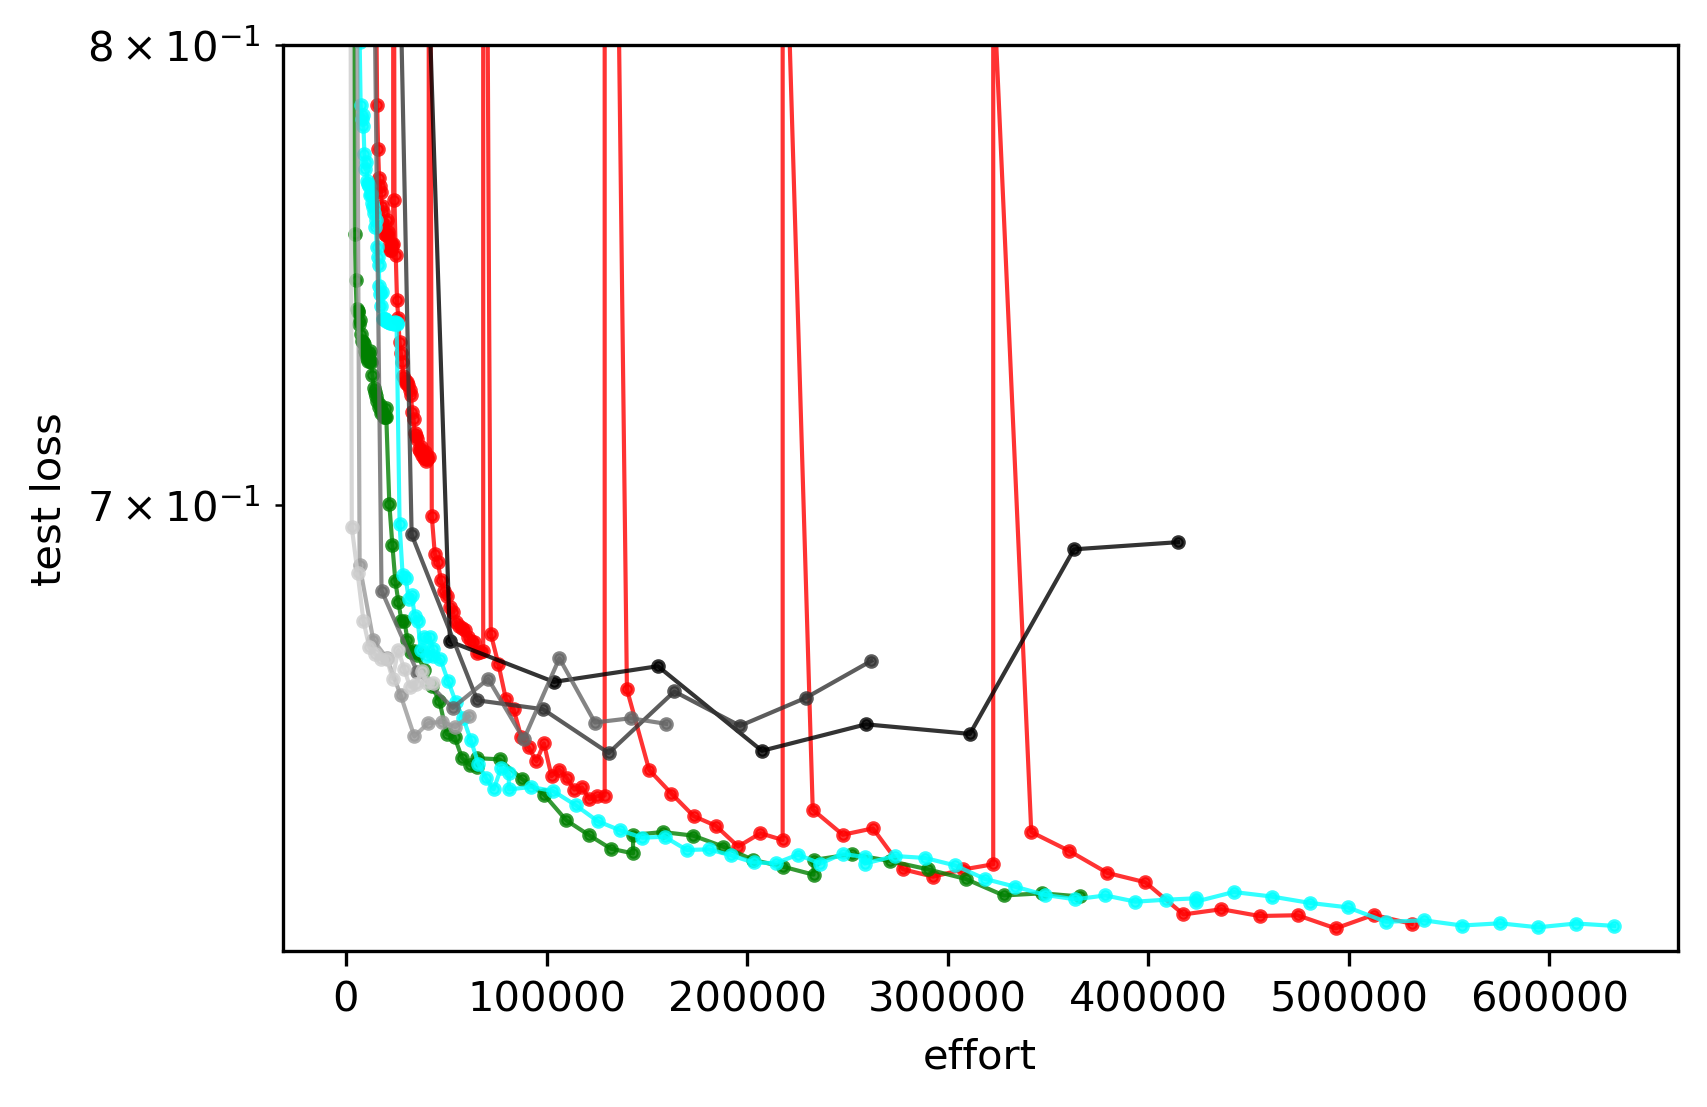

In [80]:
plt.figure(dpi=300)



# plot_effort(configs, relative_scaling_1, color='blue')
# plot_effort(configs, relative_scaling_2, color='red')
# plot_effort(configs, relative_scaling_3, color='green')

# plot_effort(configs, fg_0, colors=cm.get_cmap('Reds')(numpy .linspace(.5, 1, 2)))
# plot_effort(configs, fgs_1, colors=cm.get_cmap('Reds')(numpy .linspace(.5, 1, 2)))
# plot_effort(configs, fgsw_1, colors=cm.get_cmap('Blues')(numpy .linspace(.5, 1, 2)))

# plot_effort(configs, fgs_0, color='green')
# plot_effort(configs, fgs_1, color='green')

# plot_effort(configs, fgsw_0, colors=cm.get_cmap('Blues')(numpy .linspace(.5, 1, 2)))
# plot_effort(configs, scaling_0, colors=cm.get_cmap('Purples')(numpy .linspace(.5, 1, 2)))
# plot_effort(configs, scaling_0, color='red')
# plot_effort(configs, scaling_1, color='purple')
# plot_effort(configs, scaling_2, color='blue')
# plot_effort(configs, scaling_3, color='cyan')

# plot_effort(configs, scaling_4_2, color='yellow')

# plot_effort(configs, size_weighted_0, color='magenta')
plot_effort(configs, size_weighted_1, color='red')

# plot_effort(configs, size_weighted_together_1, color='magenta')
# plot_effort(configs, size_weighted_together_nofreeze_1, color='blue')

plot_effort(configs, test_excess_weighted_1, color='green')
plot_effort(configs, test_excess_weighted_2, color='cyan')

# plot_effort(configs, test_excess_weighted_together_1, color='red')
# plot_effort(configs, test_excess_weighted_together_2, color='magenta')



plot_effort(configs, full_trace_128, color=(0.0,0.0,0.0))
plot_effort(configs, full_trace_96, color=(0.2,0.2,0.2))
plot_effort(configs, full_trace_64, color=(0.4,0.4,0.4))
plot_effort(configs, full_trace_32, color=(0.6,0.6,0.6))
plot_effort(configs, full_trace_16, color=(0.8,0.8,0.8))


# plt.legend(['0.1', '0.01','0.001'])
plt.yscale('log')
# plt.ylim(.60, 1.1)
plt.ylim(.615, .8)

# plt.xscale('log')
# plt.xlim(1e3,7e5)

plt.xlabel('effort')
plt.ylabel('test loss')
# plt.xscale('log')
plt.show()


In [81]:
%store scaling_4_2
%store size_weighted_0
%store size_weighted_1
%store test_excess_weighted_1
%store test_excess_weighted_2
%store test_excess_weighted_together_1
%store test_excess_weighted_together_2
%store size_weighted_together_1
%store size_weighted_together_nofreeze_1
%store base_size
%store num_networks
%store configs
%store equal_sizes
%store sizes
%store dataset
%store adam_0_001
%store full_trace_128
%store full_trace_96
%store full_trace_64
%store full_trace_32
%store full_trace_16
%store fg_0
%store fgs_1
%store fgs_0
%store fgs_static_0
%store fgs_equal_0
%store fg_int_0
%store scaling_0
%store fg_int_0
%store fgs_equal_0
%store fgs_equal_1
%store fgs_equal_2
%store fgss_0
%store fgss_1
%store fgst_0
%store fgst_1
%store scaling_1
%store scaling_2
%store scaling_3
%store relative_scaling_1
%store relative_scaling_2
%store relative_scaling_3



Stored 'scaling_4_2' (dict)
Stored 'size_weighted_0' (dict)
Stored 'size_weighted_1' (dict)
Stored 'test_excess_weighted_1' (dict)
Stored 'test_excess_weighted_2' (dict)
Stored 'test_excess_weighted_together_1' (dict)
Stored 'test_excess_weighted_together_2' (dict)
Stored 'size_weighted_together_1' (dict)
Stored 'size_weighted_together_nofreeze_1' (dict)
Stored 'base_size' (int)
Stored 'num_networks' (int)
Stored 'configs' (list)
Stored 'equal_sizes' (list)
Stored 'sizes' (list)
Stored 'dataset' (tuple)
Stored 'adam_0_001' (dict)
Stored 'full_trace_128' (dict)
Stored 'full_trace_96' (dict)
Stored 'full_trace_64' (dict)
Stored 'full_trace_32' (dict)
Stored 'full_trace_16' (dict)
Stored 'fg_0' (dict)


UsageError: Unknown variable 'fgs_1'


In [ ]:
_, cross_N__N__N__N = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=None,
                      output_scale_out=None,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # no scaling

# _, cross_N__0__N__N = \
#     do_grow_train(configs, dataset,
#                   make_cross_scaling_initializer(
#                     new_scale=None,
#                     cross_scale_in=0,
#                     cross_scale_out=None,
#                     output_scale_out=None,
#                   ),
#                   make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#                   ) # no inputs from old nodes to new nodes - reduces loss spike, limits loss

# _, cross_N__N__0__N = \
#     do_grow_train(configs, dataset,
#                   make_cross_scaling_initializer(
#                     new_scale=None,
#                     cross_scale_in=None,
#                     cross_scale_out=0,
#                     output_scale_out=None,
#                   ),
#                   make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#                   ) # no inputs from new nodes to old nodes - reduces loss spike, may slightly limit loss

# _, cross_N__N__N__1 = \
#     do_grow_train(configs, dataset,
#                   make_cross_scaling_initializer(
#                     new_scale=None,
#                     cross_scale_in=None,
#                     cross_scale_out=None,
#                     output_scale_out=1.0,
#                   ),
#                   make_restoring_test_loss_growth_trigger(128, 2, 0.0),
#                   ) # outputs of new nodes are scaled to match old nodes  - no obvious effect, maybe worse spike


In [ ]:
_, cross_N__0__0__0 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=0,
                      cross_scale_out=0,
                      output_scale_out=0.0,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )        # should be same as not growing

_, cross_N__N__0__0 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0,
                      output_scale_out=0.0,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )        # should be same as not growing


In [ ]:
_, fgsws_zero_no_freeze_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_weighted_sum_ensemble_model_zero,
    train_separate=False,
    freeze_old=False,
    )

In [ ]:
_, fgstl_0 = do_train_freeze_grow_separate(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_softmax_ensemble_model,
    train_separate=False,
    )

_, fgstl_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_softmax_ensemble_model,
    train_separate=False,
    )

In [ ]:
_, fgstl_f_0 = do_train_freeze_grow_separate(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_softmax_ensemble_model,
    train_separate=False,
    freeze_old=False,
    )

_, fgstl_f_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_softmax_ensemble_model,
    train_separate=False,
    freeze_old=False,
    )

In [ ]:
_, fgst_0 = do_train_freeze_grow_separate(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_summing_ensemble_model,
    train_separate=False,
    )

_, fgst_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_summing_ensemble_model,
    train_separate=False,
    )

In [ ]:
_, fgsw_0 = do_train_freeze_grow_separate(
    sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_val_loss_weighted_ensemble_model
    )


In [ ]:

_, fgsw_1 = do_train_freeze_grow_separate(
    sizes_1, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0, loss_varname='i_val_loss'),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    make_val_loss_weighted_ensemble_model
    )


In [ ]:
_, fgs_int_0 = do_train_freeze_grow_separate(
    int_sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    )

In [ ]:
# def make_parallel_ensemble_network(sizes, dataset, make_widths, layer_args):
#     dataset_series, inputs, outputs, train_inputs, train_outputs, val_inputs, val_outputs, test_inputs, test_outputs, output_activation, run_loss = dataset
#     models = [
#         make_model_of_size(
#             inputs,
#             size,
#             make_widths,
#             output_activation,
#             layer_args,
#         ) for size in sizes]
#     model = make_averaging_ensemble_model(inputs, models)

_, fgs_static_0 = do_static_train(
    dataset,
    make_parallel_ensemble_network(delta_sizes, dataset, aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4), {'kernel_initializer': 'he_normal'}),
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    adam_0_001,
)

In [ ]:
_, scaling_0 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_1 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=.1),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_2 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=.01),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_3 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=.001),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_1_1 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=0.1, new_to_output_scale=1.0),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_2_1 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=.01, new_to_output_scale=1.0),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_1_2 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=.01, new_to_output_scale=10.0),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_4_1 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=0.0, new_to_output_scale=0.1),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, scaling_4_2 = \
    do_grow_train(configs, dataset,
                  make_var_preserving_initializer(new_to_old_scale=0.0, new_to_output_scale=0.0),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, relative_scaling_1 = \
    do_grow_train(configs, dataset,
                  make_relative_var_preserving_initializer(new_to_old_scale=.1),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, relative_scaling_2 = \
    do_grow_train(configs, dataset,
                  make_relative_var_preserving_initializer(new_to_old_scale=.01),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
_, relative_scaling_3 = \
    do_grow_train(configs, dataset,
                  make_relative_var_preserving_initializer(new_to_old_scale=.001),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  adam_0_001,
                  )

In [ ]:
base_size = 2901
num_networks = int(numpy .floor(51845 / base_size))
# num_networks = int(num_networks / 4)
equal_sizes = [base_size * (n+1) for n in range(num_networks)]
print(num_networks)

_, fgs_equal_0 = do_train_freeze_grow_separate(
    equal_sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    )

In [ ]:
base_size = 6821
num_networks = int(numpy .floor(51845 / base_size))
# num_networks = int(num_networks / 4)
equal_sizes = [base_size * (n+1) for n in range(num_networks)]
print(num_networks)

_, fgs_equal_1 = do_train_freeze_grow_separate(
    equal_sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    )

In [ ]:
base_size = 17733
num_networks = int(numpy .floor(51845 / base_size))
# num_networks = int(num_networks / 4)
equal_sizes = [base_size * (n+1) for n in range(num_networks)]
print(num_networks)

_, fgs_equal_2 = do_train_freeze_grow_separate(
    equal_sizes, dataset,
    make_restoring_test_loss_growth_trigger(128, 2, 0.0),
    aspect_test_utils.get_rectangular_widths(sum(dataset[2].shape[1:]), 4),
    adam_0_001,
    )

In [ ]:
_, cross_N__N__0_1__0_1 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.1,
                      output_scale_out=0.1,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale down outputs too?


In [ ]:
_, cross_N__N__0_01__0_01 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.01,
                      output_scale_out=0.01,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


In [ ]:
_, cross_N__N__0_001__0_001 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.001,
                      output_scale_out=0.001,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


In [ ]:
_, cross_N__N__0_001__0_001__0_001 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.001,
                      output_scale_out=0.001,
                      blend=0.001,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


In [ ]:
_, cross_N__N__0_1__0_1__0_1 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.1,
                      output_scale_out=0.1,
                      blend=0.1,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


In [ ]:
_, cross_N__N__0_0__0_1__0_0 = \
    do_grow_train(configs, dataset,
                  make_cross_scaling_initializer(
                      new_scale=None,
                      cross_scale_in=None,
                      cross_scale_out=0.0,
                      output_scale_out=0.1,
                      blend=0.0,
                  ),
                  make_restoring_test_loss_growth_trigger(128, 2, 0.0),
                  )  # better to scale self weights too? Or does this limit best loss? - low spike, good loss similar to static


In [ ]:
plt.figure(dpi=400)
# plot_delta_efficiency(configs, scaling_trace_0_01, colors = cm.get_cmap('Reds')(numpy .linspace(.5,1, 3)))
# plot_delta_efficiency(configs, increasing_trace_4_0_1, colors = cm.get_cmap('Greens')(numpy .linspace(.5,1, 2)))

plot_delta_efficiency(configs, increasing_trace_0_1,
                      colors=cm.get_cmap('Greens')(numpy .linspace(.5, 1, 2)))
plot_delta_efficiency(full_configs, full_trace, colors=['black'])
# plot_delta_efficiency(configs, scaling_trace, colors = cm.get_cmap('Reds')(numpy .linspace(.5,1, 2)))
# plot_delta_efficiency(configs, scaling_trace_0_2, colors = cm.get_cmap('Purples')(numpy .linspace(.5,1, 3)))
# plot_delta_efficiency(configs, threshold_trace_t_0_1_s_0_2, colors = cm.get_cmap('Reds')(numpy .linspace(.5,1, 2)))
plot_delta_efficiency(configs, efficiency_trace_t_1e5_s_0_1,
                      colors=cm.get_cmap('Reds')(numpy .linspace(.5, 1, 2)))
plot_delta_efficiency(configs, efficiency_trace_t_1e4_s_0_1,
                      colors=cm.get_cmap('Blues')(numpy .linspace(.5, 1, 2)))
plot_delta_efficiency(configs, efficiency_trace_t_2e5_s_0_1,
                      colors=cm.get_cmap('Purples')(numpy .linspace(.5, 1, 2)))

plt.yscale('log')
plt.xlim(300, 3e3 * 16)
# plt.xlim(100, 60e3)
# plt.ylim(.65, .72)

# plt.xscale('log')
plt.show()


In [ ]:
# plt.plot(-numpy .diff(full_trace['loss'], 1) / full_trace['size'][1:], full_trace['size'][1:])
# plt.plot(full_trace['epoch'][1:], -numpy .diff(full_trace['loss'], 1))
plt.figure(dpi=400)
plt.semilogy(full_trace['epoch'][1:], -
             numpy .diff(full_trace['loss'], 1) / full_trace['size'][1:], 'x')
